# Mini Project 2 Exercise 2
David Strube - dstrube3@gatech.edu

# NCHS Data Import
The function **nchsDataImport()** imports the NCHS data. It starts off verifying that the Python library **tika** can be imported; if it cannot be imported, it tries to install it; if the install fails, the function exits, returning an empty string. 

Next, this function uses the **parser** submodule of **tika** to read the NCHS data, specifically the **parser.from_file()** function. (Thankfully, the **from_file()** function accepts both local file paths and URLs.) 

Finally, the **nchsDataImport()** function returns the content from the data that is read.

In [1]:
fileName = "https://www.cdc.gov/nchs/data/dvs/LCWK2_2013.pdf"

def nchsDataImport():
    #Purpose: import NCHS data, return content
    try:
        import tika #https://pypi.org/project/tika/
    except:
        print("Couldn't import tika")    
        import sys
        !{sys.executable} -m pip install tika
        try:
            import tika
            print("Now it imports")
        except:
            print("Still doesn't import :(")
            return ""
    from tika import parser 
    parsed = parser.from_file(fileName)
    myContent = parsed['content']
    print("Data imported")
    return myContent

content = nchsDataImport()

Couldn't import tika
  Created wheel for tika: filename=tika-1.24-cp36-none-any.whl size=32885 sha256=d312bab43a8cf3bdb018b9076acc9c7bc21bae2913071a6b7c0801d743d48252
  Stored in directory: /root/.cache/pip/wheels/73/9c/f5/0b1b738442fc2a2862bef95b908b374f8e80215550fb2a8975
Successfully built tika


2021-02-22 14:18:01,682 [MainThread  ] [INFO ]  Retrieving https://www.cdc.gov/nchs/data/dvs/LCWK2_2013.pdf to /tmp/nchs-data-dvs-lcwk2_2013.pdf.


Now it imports


2021-02-22 14:18:01,981 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2021-02-22 14:18:02,680 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2021-02-22 14:18:03,110 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


Data imported


# Data Cleansing
The function **setIgnorableLines()** initializes a set of lines that can be ignored while parsing through the NCHS data. 

The function **dataCleansing1()** uses the file content returned from **nchsDataImport()**. It parses through the content, skipping over lines that are found in the set **ignorableLines** (initialized in **setIgnorableLines()**) and returning a list of relevant lines.

The function **dataCleansing2()** uses the list returned from **dataCleansing1()**. For each line in this input, a DataRow object is created (unless there are two lines representing the data for a single **DataRow**), using the function **dataRowFromLine()**. The function **dataCleansing2()** returns a list of **DataRow**s

In [6]:
ignorableLines = set()

def setIgnorableLines():
    #Purpose: Initialize set of ignorableLines
    ignorableLines.add("LCWK2. Deaths, percent of total deaths, and death rates for the 15 leading causes of death in 10-year age groups, by race and sex:")
    ignorableLines.add("12/31/2014 Page")
    ignorableLines.add("Tenth Revision ), race, sex, and age Number")
    ignorableLines.add("Percent of ")
    ignorableLines.add("total deaths Rate")
    ignorableLines.add("Cause of death (based on the International Classification of Diseases,")
    ignorableLines.add("Rank")
    ignorableLines.add("[Rates per 100,000 population in specified group. Rates for")
    ignorableLines.add("not distributed among age groups. Data for races other than white and black should be interpreted with caution because of inconsistencies between the reporting of race")
    ignorableLines.add("on death certificates and on censuses and surveys]")
    ignorableLines.add("United States, 2013")
    ignorableLines.add("... Category not applicable")
    ignorableLines.add("*   Figure does not meet standards of reliability or precision")
    ignorableLines.add("SOURCE: CDC/NCHS, National Vital Statistics System, Mortality 2013")

def dataCleansing1(content):
    #Purpose: take in content from NCHS import, return list of relevant lines
    myList = list()
    if content is None or len(content) == 0:
        print("Content is None or empty")
        return myList
    lines = content.split('\n')
    for line in lines:
        if len(line) > 2:
            ignorable = False
            for ignorableLine in ignorableLines:
                if line.startswith(ignorableLine):
                    ignorable = True
            if not ignorable : 
                myList.append(line)
    print("Data cleansed, part 1.")
    return myList

setIgnorableLines()
dataList1 = dataCleansing1(content)

class DataRow():
    #Purpose: Model representation of a row of data
    def __init__(self, category, rank, cause, number, percent, rate):
        self.category = category
        self.rank = rank
        self.cause = cause
        self.number = number
        self.percent = percent
        self.rate = rate

def dataRowFromLine(category, rankCause, rest):
    #Purpose: Take in category, rankCause, and the rest of a line, return a DataRow
    rank = rankCause.split(" ")[0]
    firstSpace = rankCause.index(" ")
    cause = rankCause[firstSpace + 1:]
    number = rest.split(" ")[0]
    percent = rest.split(" ")[1]
    rate = rest.split(" ")[2]
    dataRow = DataRow(category, rank, cause, number, percent, rate)
    return dataRow

def dataCleansing2(dataList):
    #Purpose: take in list of relevant lines, return list of DataRows
    allCauses = "... All causes"
    allOther = "... All other causes (Residual)"
    lastIndexOfCloseParen = 0
    isCategoryLine = True
    myList = list()
    count = 0
    category = ""
    for line in dataList:
        if isCategoryLine:
            isCategoryLine = False
            category = line
        else:
            try:
                lastIndexOfCloseParen = line.rindex(")")
            except:
                lastIndexOfCloseParen = -1
            if allCauses in line:
                rankCause = line[0:len(allCauses) + 1]                
                rest = line[len(allCauses) + 1:]
                dataRow = dataRowFromLine(category, rankCause, rest)
                myList.append(dataRow)
            elif allOther in line:
                #get all other data
                rankCause = line[0:len(allOther) + 1]
                rest = line[len(allOther) + 1:]
                dataRow = dataRowFromLine(category, rankCause, rest)
                myList.append(dataRow)
                #set flag for next line
                isCategoryLine = True
            else:
                if line[0:1].isnumeric():
                    prevLine = line
                    if lastIndexOfCloseParen == -1:
                        continue
                    rankCause = line[0:lastIndexOfCloseParen + 1]
                    rest = line[lastIndexOfCloseParen + 2:]
                    dataRow = dataRowFromLine(category, rankCause, rest)
                    myList.append(dataRow)
                else:
                    #Doesn't start numeric - Combining with prevLine
                    try:
                        lastIndexOfCloseParenInPrevLine = prevLine.rindex(")")
                        print("prevLine has unexpected close paren: " + prevLine)
                    except:
                        pass
                    newLine = prevLine + line
                    try:
                        lastIndexOfCloseParen = newLine.rindex(")")
                    except:
                        print("Error encountered while trying to parse combined line: " + newLine)
                    rankCause = newLine[0:lastIndexOfCloseParen + 1]
                    rest = newLine[lastIndexOfCloseParen + 2:]
                    dataRow = dataRowFromLine(category, rankCause, rest)
                    myList.append(dataRow)
    print("Data cleansed, part 2.")
    return myList

dataList2 = dataCleansing2(dataList1)


Data cleansed, part 1.
Data cleansed, part 2.


# Data Analysis

A new class called **ExtendedDataRow** holds all the fields as **DataRow**, plus **average** and **median**.

The function **analysis1()** performs the same statistical operations I did in Exercise 1, but in code. First it initializes a set **categories**; then for each category, finds all items in **dataList2** (the result from **dataCleansing2()**) that are in that category, putting them into a temporary list called **itemsInCategory**. Then for each item in **itemsInCategory**, it sums the **Numbers** to find the **average** while looking for the **median**. (If the number of items in **itemsInCategory** is odd, it's simply a matter of finding the item in the middle of the presorted list; if the number of items in **itemsInCategory** is even, then **median** is found by taking the average of the middle two items.) The medians and averages found for all categories in Exercise 1 matched those found here, in addition to all the other categories found here which included the rest of the data source.

The function **analysis1()** returns its results into a list of **ExtendedDataRow** items called **extendedDataList**.

Interesting digression: While debugging **analysis1()**, I attempted to confirm that each list of items in each category had a size of 17 (one **"All causes"**, one **"All other causes (Residual)"**, and 15 ranked causes). I was suprised to find that some categories had fewer, some had more. This is because some categories had ties for some ranks, and some ranks had a **Number** value of 1.

In [7]:
class ExtendedDataRow(DataRow):
    #Purpose: Represents model of row of data extended with calculated average and median
    def __init__(self, category, rank, cause, number, percent, rate, average, median):
        self.category = category
        self.rank = rank
        self.cause = cause
        self.number = number
        self.percent = percent
        self.rate = rate
        self.average = average
        self.median = median

categories = set()

allCauses = "All causes"
allOther = "All other causes (Residual)"

def analysis1():
    #Purpose: Perform analysis on dataList2 from previous step, return a new data list with average and median
    myList = list()
    for item in dataList2:
        categories.add(item.category)
    #print("Number of categories: " + str(len(categories)))
    for cat in sorted(categories):
        
        itemsInCategory = list()
        for item in dataList2:
            if item.category == cat:
                itemsInCategory.append(item)
                
        #Sum of Numbers for all items in category to find the average 
        #(excluding "All causes" and "All other causes (Residual)")
        sum = 0
        
        #Median is easy to find if the number of items in category is odd
        median = 0
        index = 0
        #If the number of items in category is even, must take the average of the two middle items
        medianSum = 0
        isEven = (len(itemsInCategory) % 2 == 0)
        medianSumIndex = len(itemsInCategory) / 2
        for item in itemsInCategory:
            if (allCauses not in item.cause) and (allOther not in item.cause):
                sum += int(item.number.replace(',',''))
                if isEven and (index == medianSumIndex or index == medianSumIndex - 1):
                    medianSum += int(item.number.replace(',',''))
                elif not isEven and (index == (len(itemsInCategory) - 1) / 2):
                    median = int(item.number.replace(',',''))
            index += 1
        average = sum / (len(itemsInCategory) - 2) # -2 for allCauses & allOther
        if isEven:
            median = medianSum / 2
        print("For category " + cat + ": average = " + str(round(average, 1)), end='')
        print("; median = " + str(median))
        for item in itemsInCategory:            
            extendedDataRow = ExtendedDataRow(item.category, item.rank, item.cause, item.number, item.percent, item.rate, average, median)
            myList.append(extendedDataRow)
        
        #Interesting digression: Not all categories have 17 items:
        if len(itemsInCategory) != 17:
            print("====================================================")
            print(cat + " has " + str(len(itemsInCategory)) + " items")
            for item in itemsInCategory:
                print(item.rank + " - " + item.cause + " - " + item.number)
            print("====================================================")

    print()
    print("Analysis complete.")
    return myList

extendedDataList = analysis1()

For category All races, both sexes, 1-4 years: average = 203.1; median = 53
For category All races, both sexes, 15-24 years: average = 1662.7; median = 193
For category All races, both sexes, 25-34 years: average = 2561.7; median = 631
For category All races, both sexes, 35-44 years: average = 3832.7; median = 1687
For category All races, both sexes, 45-54 years: average = 9970.1; median = 4619
For category All races, both sexes, 5-14 years: average = 279.5; median = 128
For category All races, both sexes, 55-64 years: average = 19191.2; median = 7135
For category All races, both sexes, 65-74 years: average = 25733.3; median = 7693
For category All races, both sexes, 75-84 years: average = 34124.7; median = 13949
For category All races, both sexes, 85 years and over: average = 41961.1; median = 17239
For category All races, both sexes, all ages: average = 137295.9; median = 56979
For category All races, female, 1-4 years: average = 86.0; median = 26
For category All races, female, 15-2

# More analysis
The function **getTop3CausesOfDeath()** displays the top 3 causes of death as defined by the top **Percents of total deaths**. The top 3 found were as follows:
* 49.7% : Malignant neoplasms (C00-C97) in category Asian or Pacific Islander, female, 45-54 years
* 49.2% : Assault (homicide) (* U01-* U02,X85-Y09,Y87.1) in category Black, male, 15-24 years
* 48.7% : Accidents (unintentional injuries) (V01-X59,Y85-Y86) in category American Indian, female, 1-4 years

The function **setRacesSexesAgesCauses()** initializes the sets **races**, **sexes**, and **ageGroups** with all the distinct values from the set of **categories**, and initializes the set **causes** from the items in **extendedDataList** where **rank** is not "...". The function **sortedAgeGroups()** returns a list of age groups that are sorted numerically, not alphabetically.

The functions **trendsForRace()**, **trendsForSex()**, and **trendsForAge()** each find the trends for a given demographic using similiar but not exact logic. (In particular, **trendsForSex()** had to search for trends in the data in **extendedDataList** carefully when the sex = "male", because the characters of "male" are also in "female".)

Some interesting correlations in the data include:
* The 3rd top cause of death, "Accidents (unintentional injuries) (V01-X59,Y85-Y86)", 48.7% in American Indian, female, 1-4 years, was one of the most common for race American Indian, found 22 times, and was one of the most common for the sex female, found 44 times, and was one of the most common for age group 1-4 years, found 8 times.
* The 2nd top cause of death, "Assault (homicide) (* U01-* U02,X85-Y09,Y87.1)", 49.2% in Black, male, 15-24 years was NOT found among the most common causes of death for race Black, and was NOT found among the sex male, but was among age group 15-24 years, found 8 times.
* The top cause of death, as measured by Percents of total deaths, "Malignant neoplasms (C00-C97)", 49.7% in Asian or Pacific Islander, female, 45-54 years, was one of the most common for race Asian or Pacific Islander, found 22 times, and was among most common for the sex female, found 44 times, and was one of the most common for age group 45-54 years, found 8 times.

In [4]:
top3 = list()

def getTop3CausesOfDeath():
    """
    Just comparing the first two categories from the original data source, "AR,BS,AA" & "AR,BS,1-4",
    Diseases of heart (I00-I09,I11,I13,I20-I51) wins just by Numbers, but
    Accidents (unintentional injuries) (V01-X59,Y85-Y86) wins by Percent of total deaths.
    
    Compare the top rated Percent of total deaths across all categories, to see which are the top 3
    """
    topN = dict()
    
    for item in extendedDataList:
        if "..." not in item.rank:
            topN.update({float(item.percent):item})
    count = 0
    print("Top 3 causes of death (by Percent of total deaths):")
    for key in sorted(topN.keys(), reverse=True):
        print(str(key) + "% : " + topN.get(key).cause + " in category " + topN.get(key).category)
        count += 1
        top3.append(topN.get(key))
        if count > 2:
            break

getTop3CausesOfDeath()
print()

races = set()
sexes = set()
ageGroups = set()
causes = set()

def setRacesSexesAgesCauses():
    #Purpose: Populate the race, sex, and age sets from categories
    prevRaceLen = 0
    prevAgeLen = 0
    for cat in categories:
        subCats = cat.split(",")
        if "All races" not in subCats[0]:
            races.add(subCats[0])
        if "all ages" not in subCats[2]:
            ageGroups.add(subCats[2])
        """if len(races) > prevRaceLen:
            prevRaceLen = len(races)
            print("Added race: " + subCats[0])
        if len(ageGroups) > prevAgeLen:
            prevAgeLen = len(ageGroups)
            print("Added age group: " + subCats[2])"""
    #Note: Until the list of sexes increases from just "male", "female", and "both sexes", 
    #that collection can be initialized manually, excluding "both sexes"
    sexes.add("male")
    sexes.add("female")
    for item in extendedDataList:
        #Excluding All causes and All other...
        if "..." not in item.rank:
            causes.add(item.cause)

setRacesSexesAgesCauses()

def sortedAgeGroups():
    #Purpose: Get age groups sorted numerically, not alphabetically
    sortedAges = list()
    ageGroupsCopy = ageGroups.copy()
    for ageGroup in sorted(ageGroupsCopy):
        if ageGroup[2] == "-":
            sortedAges.append(ageGroup)
            ageGroupsCopy.remove(ageGroup)
    for ageGroup in sorted(ageGroupsCopy):
        sortedAges.append(ageGroup)
    return sortedAges

def trendsForRace(race):
    #Purpose: Find trends for given race

    #Most common causes
    mostCommon = dict()
    for item in extendedDataList:
        #Excluding all ages and both sexes
        if "All" not in item.category and "both" not in item.category and race in item.category \
            and "All" not in item.cause:
            count = mostCommon.get(item.cause, 0)
            mostCommon.update({item.cause : count+1})
    count = 0
    print("The following causes of death for race " + race + " were the most common, found ", end='')
    for value in sorted(mostCommon.values(), reverse=True):
        print(str(value) + " times: ")
        for key in mostCommon.keys():
            if mostCommon.get(key) == value:
                print(key)
        break
    print()
    
    #Causes not found
    founds = set(mostCommon.keys())
    notFounds = causes.difference(founds)
    print("The following " + str(len(notFounds)) + " causes of death for race " + race + " were not found: ")
    for notFound in notFounds:
        print(notFound)
    print()

def trendsForSex(sex):
    #Purpose: Find trends for given sex

    #Most common causes
    mostCommon = dict()
    for item in extendedDataList:
        #Excluding all ages and all races
        if "All" not in item.category and "all" not in item.category and "All" not in item.cause:
            #Since the characters for "male" are in "female", have to be a little kludgey with this...
            if (sex == "female" and sex in item.category) or \
                (sex == "male" and sex in item.category and "female" not in item.category):
                count = mostCommon.get(item.cause, 0)
                mostCommon.update({item.cause : count+1})
    count = 0
    print("The following causes of death for sex " + sex + " were the most common, found ", end='')
    for value in sorted(mostCommon.values(), reverse=True):
        print(str(value) + " times: ")
        for key in mostCommon.keys():
            if mostCommon.get(key) == value:
                print(key)
        break
    print()
    
    #Causes not found
    founds = set(mostCommon.keys())
    notFounds = causes.difference(founds)
    print("The following " + str(len(notFounds)) + " causes of death for sex " + sex + " were not found: ")
    for notFound in notFounds:
        print(notFound)
    print()
    
def trendsForAge(ageGroup):
    #Purpose: Find trends for given age group

    #Most common causes
    mostCommon = dict()
    for item in extendedDataList:
        #Excluding both sexes and all races
        if "All" not in item.category and "both" not in item.category and "All" not in item.cause \
            and ageGroup in item.category:
            count = mostCommon.get(item.cause, 0)
            mostCommon.update({item.cause : count+1})
    count = 0
    print("The following causes of death for age group" + ageGroup + " were the most common, found ", end='')
    for value in sorted(mostCommon.values(), reverse=True):
        print(str(value) + " times: ")
        for key in mostCommon.keys():
            if mostCommon.get(key) == value:
                print(key)
        break
    print()
    
    #Causes not found
    founds = set(mostCommon.keys())
    notFounds = causes.difference(founds)
    print("The following " + str(len(notFounds)) + " causes of death for age group" + ageGroup + " were not found: ")
    for notFound in notFounds:
        print(notFound)
    print()

def findTrends():
    #Purpose: Find trends for races, sexes, and ageGroups
    for race in sorted(races):
        trendsForRace(race)
    for sex in sorted(sexes):
        trendsForSex(sex)
    for ageGroup in sortedAgeGroups():
        trendsForAge(ageGroup)

findTrends()

Top 3 causes of death (by Percent of total deaths):
49.7% : Malignant neoplasms (C00-C97) in category Asian or Pacific Islander, female, 45-54 years
49.2% : Assault (homicide) (*U01-*U02,X85-Y09,Y87.1) in category Black, male, 15-24 years
48.7% : Accidents (unintentional injuries) (V01-X59,Y85-Y86) in category American Indian, female, 1-4 years

The following causes of death for race American Indian were the most common, found 22 times: 
Accidents (unintentional injuries) (V01-X59,Y85-Y86)
Malignant neoplasms (C00-C97)

The following 5 causes of death for race American Indian were not found: 
Anemias (D50-D64)
Meningitis (G00,G03)
Shigellosis and amebiasis (A03,A06)
Pneumoconioses and chemical effects (J60-J66,J68)
Diseases of appendix (K35-K38)

The following causes of death for race Asian or Pacific Islander were the most common, found 22 times: 
Accidents (unintentional injuries) (V01-X59,Y85-Y86)
Malignant neoplasms (C00-C97)
Diseases of heart (I00-I09,I11,I13,I20-I51)

The followi

# Visualizations
The function **chartTop3()** displays pie charts of the top 3 causes of death (as measured by **Percent of total deaths**) found in the previous step. Note that the causes of death for smaller pie pieces tend to overlap. Still, the biggest cause of death in each of these  categories is clearly the most significant factor to be aware of in each of these categories.

Asian or Pacific Islander, female, 45-54 years


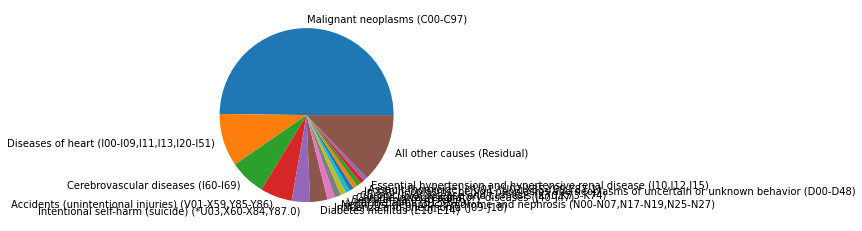


Black, male, 15-24 years


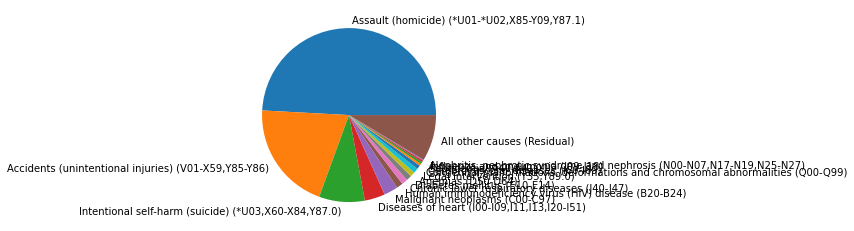


American Indian, female, 1-4 years


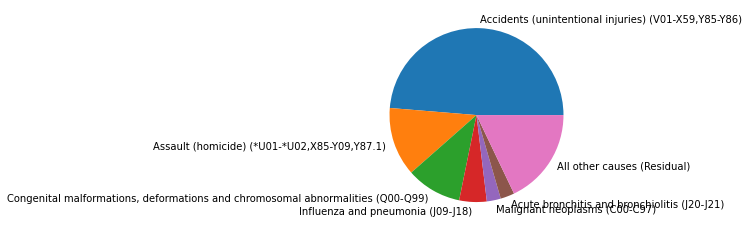

In [5]:
import matplotlib.pyplot as plt
#If import no good, follow the above pattern for tika; but should be good- matplotlib is pretty common.

#allow plots to appear within the notebook:
%matplotlib inline
#%matplotlib notebook

def chartTop3():
    #Purpose: Chart the top 3 causes of death (as measured by Percent of total deaths)
    for top in top3:
        topCategory = top.category
        categoryPercents = list()
        categoryCauses = list()
        print(topCategory)
        for item in extendedDataList:
            if item.category == topCategory:
                if allCauses not in item.cause : 
                    categoryPercents.append(item.percent)
                    categoryCauses.append(item.cause)
        plt.pie(categoryPercents, labels=categoryCauses)
        plt.show()
        print()

chartTop3()